# 8. Logistic regression

Previously, we learned about linear regression, which is a method to predict continuous numerical values of the response variable. Examples of such values are the price of a house, or the temperature of a city.

In this notebook, we will learn about logistic regression, which is used to predict binary outcomes. A binary outcome means that there are only two options: the event happens (1) or the event does not happen (0). Examples of binary outcomes are whether a patient has a disease or not, whether a customer will buy a product or not, or whether a student will pass an exam or not.

It turns out that the linear regression machinery can be adapted to predict binary outcomes. The key idea is to transform the output of the linear regression into a probability. This is done by using the logistic function, which is a mathematical function that maps any real number *x* to *y* values in the interval [0, 1]:

$$
y = \frac{1}{1 + e^{-x}}
$$


The following Python code plots the mapping of the logistic function, which is an example of a sigmoid (or, s-shaped) function.

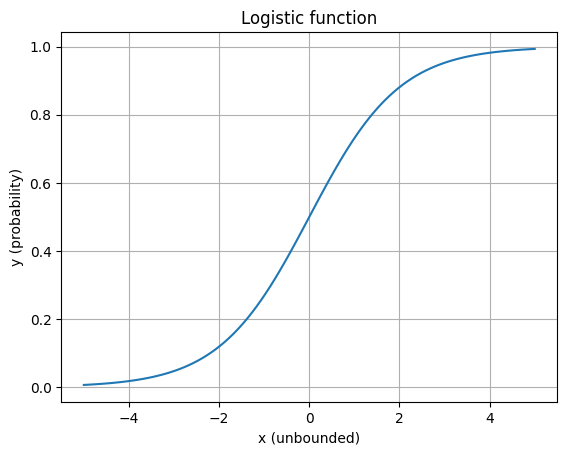

In [47]:
# visualize the sigmoid function
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-5, 5, 100)
y = 1 / (1 + np.exp(-x))

plt.plot(x, y)
plt.xlabel('x (unbounded)')
plt.ylabel('y (probability)')
plt.title('Logistic function')
plt.grid()

plt.show()

In a nutshell, the idea of logistic regression is to apply the linear regression machinery to predict a continuous value, and then to transform this value into a probability using the logistic function. The value can either be used to make a binary decision, or consumed as such as a probability.

In logistic regression, the goal is to minimize the log-loss function, which is a measure of how well the model predicts the probability of the outcome. The log-loss function is defined as:

$$

\text{LogLoss} = -\frac{1}{N} \sum_{i=1}^{N} [y_i \log(p_i) + (1 - y_i) \log(1 - p_i)]

$$

where:

- $N$ is the number of observations.
- $y_i$ is the true class label of the $i$-th observation.
- $p_i$ is the predicted probability of the $i$-th observation.

The log-loss function penalizes the model more when it predicts a high probability for the wrong class, and less when it predicts a low probability for the wrong class.

## Prerequisites for logistic regression

There are a few prerequisites for logistic regression:

- The target variable should be binary. Some implementations can handle multi-class classification, but the basic idea is to predict binary outcomes.

- There should be a linear relationship between each predictor variable and the log-odds of the outcome.

- Observations should be independent of each other.

- Predictor variables should not be perfectly collinear (i.e. highly correlated). Multicollinearity among predictors can lead to unstable estimates.

## Building and validating a logistic regression model

The following dataset contains information about patients that have previously experienced a stroke. The subjects have been followed up for a period of time, and the dataset contains information about whether the patient has had a second stroke or not. The goal is to make a predictive model that can predict whether a future patient will have a second stroke or not.


In [48]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# read data (replace with your own path)
df = pd.read_csv('datasets/stroke/stroke_v1.csv', sep=',')
df.head(10)

,ID,Weight,Smoking,Exercise,Cholesterol,Income,Exphappiness,Birthyear,Sex,Stroke
0,1,117,1,2,8.0,1080,27,1913,M,1
1,2,62,0,8,5.5,2120,55,1949,M,0
2,3,74,0,6,4.8,3170,65,1976,M,0
3,4,77,0,5,4.2,4740,61,1973,F,0
4,5,67,0,8,4.5,1900,53,1929,M,0
5,6,76,0,6,6.2,3410,72,1959,F,0
6,7,63,0,7,4.1,3640,71,1979,F,0
7,8,75,0,5,5.2,2500,99,1960,F,0
8,9,70,0,6,4.9,2110,48,1922,F,0
9,10,82,0,5,5.8,2560,34,2007,F,1


In [49]:
# re-encode sex
df['Sex'] = df['Sex'].map({'M': 1, 'F': 2}).astype('int64')

# drop id
df.drop('ID', axis=1, inplace=True)

# convert to floats (except for the target variable)
for col in df.columns.values[:-1]:
    if df[col].dtype != 'float64':
        df[col] = df[col].astype(dtype='float64')

df.head(10)

,Weight,Smoking,Exercise,Cholesterol,Income,Exphappiness,Birthyear,Sex,Stroke
0,117.0,1.0,2.0,8.0,1080.0,27.0,1913.0,1.0,1
1,62.0,0.0,8.0,5.5,2120.0,55.0,1949.0,1.0,0
2,74.0,0.0,6.0,4.8,3170.0,65.0,1976.0,1.0,0
3,77.0,0.0,5.0,4.2,4740.0,61.0,1973.0,2.0,0
4,67.0,0.0,8.0,4.5,1900.0,53.0,1929.0,1.0,0
5,76.0,0.0,6.0,6.2,3410.0,72.0,1959.0,2.0,0
6,63.0,0.0,7.0,4.1,3640.0,71.0,1979.0,2.0,0
7,75.0,0.0,5.0,5.2,2500.0,99.0,1960.0,2.0,0
8,70.0,0.0,6.0,4.9,2110.0,48.0,1922.0,2.0,0
9,82.0,0.0,5.0,5.8,2560.0,34.0,2007.0,2.0,1


At this point, the data frame will be split into the explanatory variables (features) and the target variable.

After that, the values of the features will be standardized. While this is not strictly necessary for logistic regression, it is a good practice to standardize the features, because it makes the model more robust and easier to interpret.

> As the sklearn implementation of the logistic regression is considered, standardization is vital. The algorithm uses so called L2 regularization, which is a technique to prevent overfitting. Regularization works by adding a penalty term to the loss function, which is proportional to the size of the coefficients. If the features are not standardized, the regularization term will penalize the features with larger values more than the features with smaller values. This can lead to biased coefficients and a model that is harder to interpret.

In [50]:
X, y = df.iloc[:,:8], df.iloc[:,8]

# standardize features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head(10)

,Weight,Smoking,Exercise,Cholesterol,Income,Exphappiness,Birthyear,Sex
0,2.745321,1.866629,-1.621745,1.785293,-1.581660,-1.430214,-2.020743,-0.988071
1,-1.202406,-0.535725,1.497996,-0.120768,-0.640621,0.236702,-0.317710,-0.988071
2,-0.341084,-0.535725,0.458082,-0.654465,0.309466,0.832029,0.959564,-0.988071
3,-0.125753,-0.535725,-0.061875,-1.111920,1.730073,0.593899,0.817645,1.012073
4,-0.843522,-0.535725,1.497996,-0.883192,-0.839687,0.117637,-1.263839,-0.988071
5,-0.197530,-0.535725,0.458082,0.412929,0.526629,1.248759,0.155354,1.012073
6,-1.130629,-0.535725,0.978039,-1.188162,0.734743,1.189226,1.101484,1.012073
7,-0.269307,-0.535725,-0.061875,-0.349495,-0.296780,2.856142,0.202661,1.012073
8,-0.628191,-0.535725,0.458082,-0.578223,-0.649670,-0.180027,-1.594984,1.012073
9,0.233131,-0.535725,-0.061875,0.107959,-0.242489,-1.013485,2.426064,1.012073


In [51]:
# build and fit model
reg = LogisticRegression(solver='lbfgs')
reg.fit(X,y)

print("Coefficients: ",reg.coef_)
print("Intercept: ", reg.intercept_)


Coefficients:  [[ 1.00440714  0.16707594 -0.49086543  0.30697732 -0.04086465 -0.01986069
   0.15470113 -0.04488196]]
Intercept:  [-0.57794563]


Using mathematical notation, the logistic regression model for estimating the probability of a stroke is:

$$
\hat{p} = 1.0044 \cdot Weight + 0.1671 \cdot Smoking - 0.4909 \cdot Exercise + 0.3070 \cdot Cholesterol - 0.0409 \cdot Income - 0.0199 \cdot Exphappiness + 0.1547 \cdot Birthyear - 0.0449 \cdot Sex - 0.5779
$$

In the formula, values $x_1$ to $x_8$ are the standardized values of the input features. The model predicts the probability of a stroke. When used as a binary classifer, the decision boundary is at 0.5, meaning that if the probability is greater than 0.5, the model predicts that the patient will have a stroke. Otherwise, the model predicts that the patient will not have a stroke.

For evaluation of the model, let's carry out a 10-fold cross-validation and print the confusion matrix.



Accuracy: 0.76
Confusion Matrix:
 [[512  88]
 [148 252]]


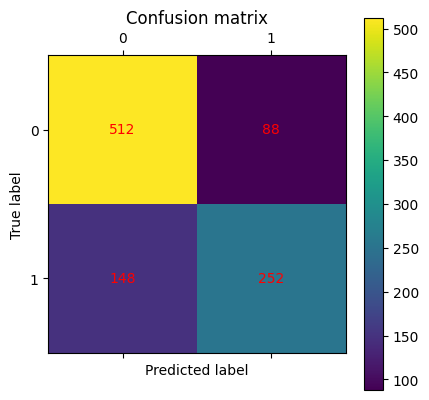

In [52]:
# cross-validation
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

y_pred = cross_val_predict(estimator=reg, X=X, y=y, cv=10)

cm = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)

print("Accuracy: %0.2f" % accuracy)
print("Confusion Matrix:\n", cm)

# visualize confusion matrix
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
# include counts
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()



The model seems to predict the outcome quite well, with an accuracy of 0.76. Contransting this to the performance of a random classifier, which would have an accuracy of 0.5, the model seems to be doing a decent job.

## Getting probability estimates

Let's say we want to predict the probability of a patient having a stroke, after they have provided the information of their current status. The following interactive Python code allows you to input the values of the features, and get the probability of a stroke.


In [58]:
# interactive prediction

features=['Weight', 'Smoking', 'Exercise', 'Cholesterol', 'Income', 'Exphappiness', 'Birthyear', 'Sex']

Xi = pd.DataFrame(columns=features)

# read input data
for f in features:
    val = input(f"Enter value for feature: {f}")
    Xi[f] = [float(val)]

# get probability estimate
Xi = pd.DataFrame(scaler.transform(Xi), columns=Xi.columns)
p = reg.predict_proba(Xi)[:,1]

# output
print("Probability of stroke: %0.2f" % p[0])


Probability of stroke: 0.81


## Estimating feature importance with permutation importance

In linear regression, feature importance could easily be deduced from the coefficients of the model, provided that the features are standardized. In logistic regression, the coefficients are not directly interpretable as feature importance, because the coefficients are transformed by the logistic function.

However, sklearn provides a mechanism called permutation importance, which can be used to estimate the importance of features. The idea is to shuffle the values of a feature, and then measure how much the model's performance decreases. The more the performance decreases, the more important the feature is. Let's compute the permutation importance of the features for the stroke prediction model.


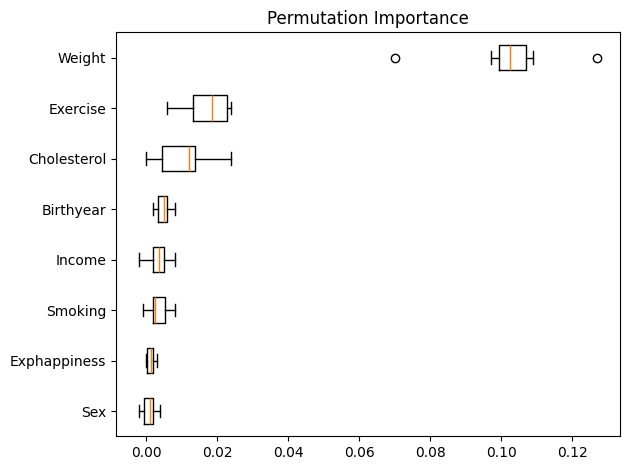

In [61]:
# feature importance
from sklearn.inspection import permutation_importance

result = permutation_importance(reg, X, y, n_repeats=10, scoring="accuracy", random_state=0, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, tick_labels=X.columns[sorted_idx])
ax.set_title("Permutation Importance")
fig.tight_layout()
plt.show()


The plot shows the importance of each feature in the model. The higher the value, the more important the feature is. The most important feature is `Weight`, followed by `Exercise` and `Cholsterol`. The least important feature is `Sex`.

Let's look in detail at how the permutation importances were computed. The idea is to repeatedly shuffle the values of a feature, and then measure how much the model's performance decreases. As the values are shuffled, the feature is expected to have only a small impact on the response variable, and even that small impact is caused by random noise. As a consequence, when we shuffle a meaningless feature, the model's performance should not decrease much. On the other hand, if the feature is of high importance, the model's performance should decrease significantly.

### Phases of permutation importance evaluation

1. **Model Baseline Performance**:
   - First, evaluate the model’s performance on the original dataset. This establishes the baseline performance metric (e.g., accuracy).

2. **Iterate Over Each Feature**:
   - For each feature (column) in the dataset, perform the permutation process. This means handling one feature at a time.

3. **Permute the Feature Values**:
   - Select one feature to permute. Shuffle the values of this feature randomly, while keeping the values of other features unchanged. For example, if the original feature values are:
     ```
     | Feature1 | Feature2 |
     |----------|----------|
     |    1     |    5     |
     |    2     |    6     |
     |    3     |    7     |
     ```
     After permuting `Feature1`, it might look like this:
     ```
     | Feature1 | Feature2 |
     |----------|----------|
     |    2     |    5     |
     |    1     |    6     |
     |    3     |    7     |
     ```

4. **Evaluate the Model with Permuted Data**:
   - Train or evaluate the model using the permuted dataset. This will give you a performance metric based on how well the model performs with the shuffled values.

5. **Repeat Permutation**:
   - Repeat the permutation process multiple times (`n_repeats`), each time shuffling the feature values and evaluating the model’s performance. This produces a distribution of performance metrics for each feature.

6. **Calculate Average Performance Drop**:
   - Compute the average performance drop across all permutation iterations for each feature. This average represents the mean decrease in model performance when the feature’s values are permuted.

7. **Compare Features**:
   - Compare the average performance drop for each feature. Features that cause a significant drop in performance when permuted are considered more important. A larger performance drop indicates that the feature is crucial for the model’s predictions.


## Multiclass classification with logistic regression

Logistic regression is by nature a binary classifier, meaning that it can only predict binary outcomes. However, it can be extended to handle multi-class classification by using a technique called one-vs-rest (OvR) or one-vs-all (OvA) classification. The idea is to train a separate binary classifier for each class, and then combine the results to make a multi-class prediction.

The sklearn implementation of logistic regression can handle multi-class classification out of the box. If the target variable has more than two classes, the algorithm will automatically switch to the multi-class mode (by default OvR):
- A binary classifier is built for each value of the categorical response variable.
- For each binary classifier, all remaining values of the response variable are lumped together.
- Finally, for each observation, the classifier that provides a classification with a highest confidence score, outputs the final class.

The following image shows the idea of one-vs-rest classification:

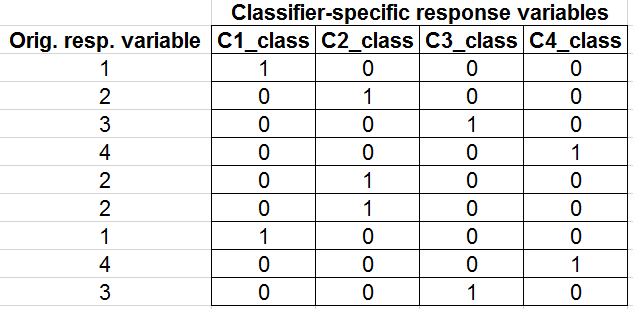

In [63]:
from IPython.display import Image,display;display(Image(filename="img/ovr.png"))